In [50]:
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt

%matplotlib inline

path_file = "../../data/crime_homicide_subset.csv"
raw_data = sc.textFile(path_file)
data_header = raw_data.first() # dit is gwn de header mocht je da voor iets willen gebruiken want hieronder halen wij die weg
data= (raw_data.filter(lambda x: 'year,mont,week,hour,start,day,report_dat,shift,offense,method,block,district,PSA,ward,ANC,neighborhood_cluster,block_group,census_track,voting_percinct,ccn,XBLOCK,YBLOCK,start_date,end_date,lat,long,accuracy'not in x)
       .map(lambda x: x.split(",")))


#data bevat alles buiten de header ><

In [51]:
"""
testing dat alles werk 
probeer de testing altijd in een apart cel te doen omdat het anders traag gaat 
testing is meestal sneller dan dan data verwerking 
"""

#raw_data.take(10)
data.take(10)

[[u'year',
  u'mont',
  u'week',
  u'hour',
  u'start',
  u'day',
  u'REPORT_DAT',
  u'SHIFT',
  u'OFFENSE',
  u'METHOD',
  u'BLOCK',
  u'DISTRICT',
  u'PSA',
  u'WARD',
  u'ANC',
  u'NEIGHBORHOOD_CLUSTER',
  u'BLOCK_GROUP',
  u'CENSUS_TRACT',
  u'VOTING_PRECINCT',
  u'CCN',
  u'XBLOCK',
  u'YBLOCK',
  u'START_DATE',
  u'END_DATE',
  u'lat',
  u'long',
  u'accuracy'],
 [u'2011',
  u'1',
  u'1',
  u'6',
  u'1/01/2011',
  u'0',
  u'1/01/2011 6:55',
  u'MIDNIGHT',
  u'SEX ABUSE',
  u'OTHERS',
  u'600 - 699 BLOCK OF 46TH PLACE SE',
  u'6',
  u'604',
  u'7',
  u'7F',
  u'Cluster 33',
  u'009907 2',
  u'9907',
  u'Precinct 103',
  u'11000272',
  u'405593',
  u'134807',
  u'1/01/2011 2:19',
  u'1/01/2011 6:00',
  u'38.8421079',
  u'-76.9874456',
  u'route'],
 [u'2011',
  u'1',
  u'1',
  u'17',
  u'1/01/2011',
  u'0',
  u'1/01/2011 17:29',
  u'EVENING',
  u'SEX ABUSE',
  u'OTHERS',
  u'100 - 299 BLOCK OF P STREET NW',
  u'5',
  u'501',
  u'5',
  u'5E',
  u'Cluster 21',
  u'004600 2',
  u'4600'

In [52]:
#Deze dataset bevat alles waar het woord homicide in voorkomt 
#met andere woorden alles wat jee hiermee doet heeft met homicide maken zie test (alle jaren , locatie, dagen,...)
homicide_data= data.filter(lambda x: 'HOMICIDE' in x) 

#testing => deze stuk code moet samengevoegd worden met die van hieronder ik doe het gwn zo voor visualisatie
#zodat je kan zien wat er gebeurd 
homicide_data.take(10)


[[u'2011',
  u'1',
  u'2',
  u'0',
  u'1/01/2011',
  u'1',
  u'1/02/2011 0:00',
  u'MIDNIGHT',
  u'HOMICIDE',
  u'GUN',
  u'3400 - 3499 BLOCK OF 13TH PLACE SE',
  u'7',
  u'705',
  u'8',
  u'8E',
  u'Cluster 38',
  u'007304 1',
  u'7304',
  u'Precinct 120',
  u'11000654',
  u'401104.1697',
  u'130427.7926',
  u'1/02/2011 6:58',
  u'1/02/2011 6:59',
  u'38.882092',
  u'-76.9265859',
  u'street_address'],
 [u'2011',
  u'1',
  u'2',
  u'0',
  u'1/01/2011',
  u'1',
  u'1/02/2011 0:00',
  u'MIDNIGHT',
  u'HOMICIDE',
  u'GUN',
  u'4505  - 4599 BLOCK OF NEW HAMPSHIRE AVENUE NW',
  u'4',
  u'407',
  u'4',
  u'4C',
  u'Cluster 18',
  u'002301 2',
  u'2301',
  u'Precinct 46',
  u'11000735',
  u'398521',
  u'142020',
  u'1/02/2011 13:21',
  u'1/02/2011 0:00',
  u'38.8915005',
  u'-76.9239798',
  u'route'],
 [u'2011',
  u'1',
  u'2',
  u'0',
  u'1/01/2011',
  u'5',
  u'1/06/2011 0:00',
  u'MIDNIGHT',
  u'HOMICIDE',
  u'GUN',
  u'4200 - 4399 BLOCK OF GAULT PLACE NE',
  u'6',
  u'602',
  u'7',
  u'7

In [53]:
"""
Haal alle moorden op (normaal moet deze stap niet aangezien het count die al verwerkt ik doe het gwn voor de testing voor u)
Wij doen [8] omdat je hierboven kan zien dat het woord 'homicide' op het 8ste plaats staat in de array
tellend van 0 zie testing voor resultaat
"""
homicide= homicide_data.map(lambda x: x[8])

#totaal aantal moorden (zie hieronder) haal alle moorden op en telt ze 
homicide_count =homicide.count()

"""
nu dat wij alle moorden hebben kunnen wij daarop verder gaan filteren 
in deze geval gaan we opzoek naar alle moorden met een wapen 'gun'
dit doen we in twee stappen (normaal aan elkaar maar voor u doe ik ze apart)

stap 1 eerst gaan we opzoek naar de veldnr waar het woord 'gun' gebruikt wordt in onze nieuwe dataset (zie hierboven)
        zoals u kan zien wordt het in de 9de veld gebruikt na 'homicide' (method)
stap 2 nu dat wij die veld te pakken hebben gaan we nog is filteren deze keer op alles waar het woord 'gun' in voorkomt 
        want zoals je kunt zien heeft deze veld (9de veld) meer dan 1 waarde bv: gun knife en other (wij moeten gun hebben )
stap 3 : tel ze 
""" 

#stap 1
methods = homicide_data.map(lambda x: x[9])

#stap 2 haal de 'gun' eruit (want je heb gun, knife en other pas dezee werkwijze toe om de anderee eruit te halen)
method_gun = methods.filter(lambda x: 'GUN' in x)

#stap 3 tel ze (dit geeft de aantal moorden met een gun)
method_gun_count = method_gun.count()

In [54]:
#testing 
#dataset result & print werken niet goed samen eje moet één van de twee tonen niet dat het uitmaakt VISUALISATIE

#homicide.take(10)  #voor onder elkaar

#print homicide_count 

#methods.take(10)  # geeft alle methodee terug wil je alles zien dan doe je .collect() ik doe take omdat het sneller is 
#methods.collect()

#method_gun.take(50) # als je dit run zie je enkel gun gun gun gun enz 

print method_gun_count # weergeef het aantal gun moorden 

444


In [55]:
#VISUALISATIE (1)

#totaal MOORDEN met een GUN 
labels_gun_homicide = ['niet met een wapen ', 'met wapen']
fracs_gun_homicide = [homicide_count, method_gun_count]
explode = [0, 0.10]

'Van alle {0} moorden die werden gepleegd gebeurde er {1} met een wapen'.format(homicide_count, method_gun_count)
#nu gaan we dit opzetten in een grafiek

'Van alle 619 moorden die werden gepleegd gebeurde er 444 met een wapen'

([<matplotlib.patches.Wedge at 0xc04f8d0>,
 [<matplotlib.text.Text at 0xc1b2c88>, <matplotlib.text.Text at 0xc1c1d68>],
 [<matplotlib.text.Text at 0xc1c10b8>, <matplotlib.text.Text at 0xc1cd160>])

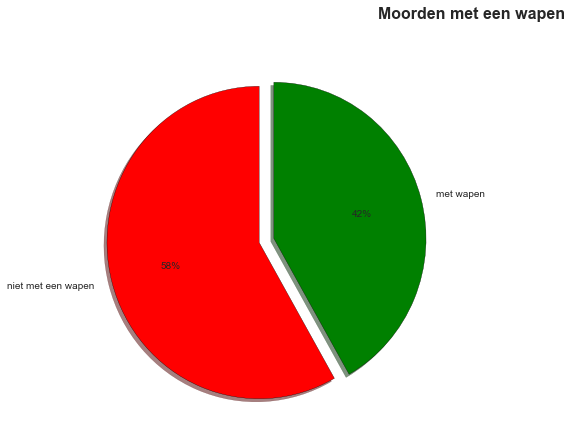

In [56]:
#VISUALISATIE (2)

#moorden met een wapen
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Moorden met een wapen ', fontsize=16, fontweight='bold')

ax_gun_homicide = fig.add_subplot(121)
ax_gun_homicide.pie(fracs_gun_homicide, explode=explode, labels=labels_gun_homicide, colors=('r', 'g'), 
              autopct='%1.0f%%', shadow=True, startangle=90)
#huishoudelijk geweld met als moord als gevolg